In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy

#Import some image analysis functions
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf

import sys
import pickle

##################################################################################################
# CHANGE THIS TO THE PATH WHERE THE DDM CODE IS (GET FROM GITHUB IF YOU HAVEN'T YET)             #
path_to_ddm_code = "C:\\Users\\rmcgorty\\Documents\\GitHub\\Differential-Dynamic-Microscopy---Python\\"
##################################################################################################

sys.path.append(path_to_ddm_code)
import radiav
import tiff_file
import ddm_clean as ddm

C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\rmcgorty\Documents\GitHub\Differential-Dynamic-Microscopy---Python\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
%matplotlib notebook

Imports not working? Make sure to grab the [DDM repository from GitHub](https://github.com/rmcgorty/Differential-Dynamic-Microscopy---Python). 

Don't know what all those scipy.ndimage functions are? [Check out the documentation](https://docs.scipy.org/doc/scipy/reference/ndimage.html). 

In [3]:
def im_corr(image, filter=False, filtersize=80):
    '''
    This function computes the image correlation. 
    Inputs:
        image - the 2D matrix of the image
        filter (optional) - boolean, defaults to False. Whether or not to filter image using the uniform filter
        filtersize (optional) - defaults to 80. Size of filter
    Outputs:
        corr_im - the correlation (same size as input image)
        rav_corr - radially averaged correlation
    '''
    
    #If the 'filter' optional argument is true, then filter the image
    if filter:
        image = filtimage(image, filtersize = filtersize)
        
    #Subtract of the mean and divide by standard deviation (so that the maximum
    #  of the correlation function will be 1)
    image = 1.0*image-image.mean()
    image = image/image.std()
    
    #Use Fourier transforms to calculate the correlation
    corr_im = fftshift(ifft2(fft2(image)*np.conj(fft2(image))))/(image.shape[0]*image.shape[1])
    corr_im = corr_im.astype(np.float32)
    
    #Compute radial average
    rav_corr = ddm.newRadav(corr_im)
    
    
    return corr_im, rav_corr

def filtimage(image, filtersize=80):
    '''
    Filters image using the scipy.ndimage function uniform_filter
    '''
    image = image*1.0 - uf(image,filtersize)
    return image

<ipython-input-6-7b4b7cb45013>:25: RuntimeWarning: divide by zero encountered in true_divide
  cos2theta = np.cos(2*np.arctan(1.0*xx/yy))
<ipython-input-6-7b4b7cb45013>:25: RuntimeWarning: invalid value encountered in true_divide
  cos2theta = np.cos(2*np.arctan(1.0*xx/yy))
<ipython-input-3-d5574b746b28>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_im = corr_im.astype(np.float32)


<IPython.core.display.Javascript object>


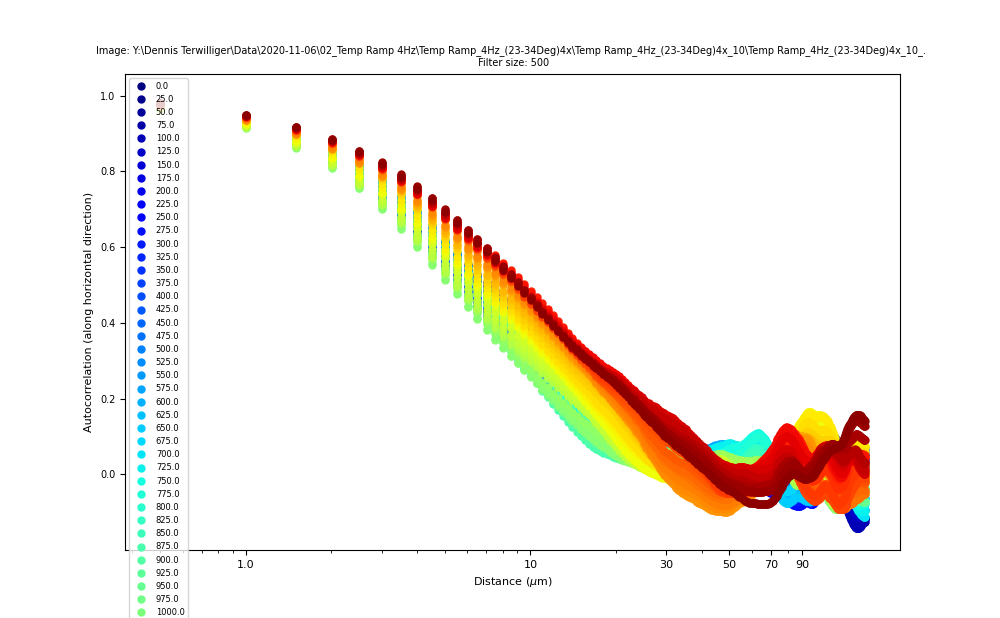

<IPython.core.display.Javascript object>


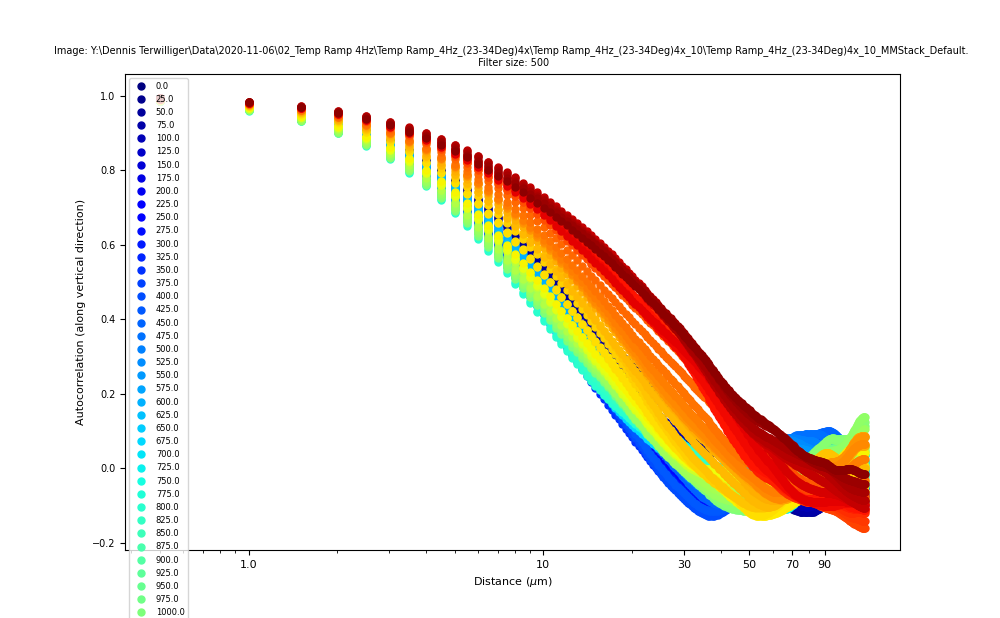

<IPython.core.display.Javascript object>


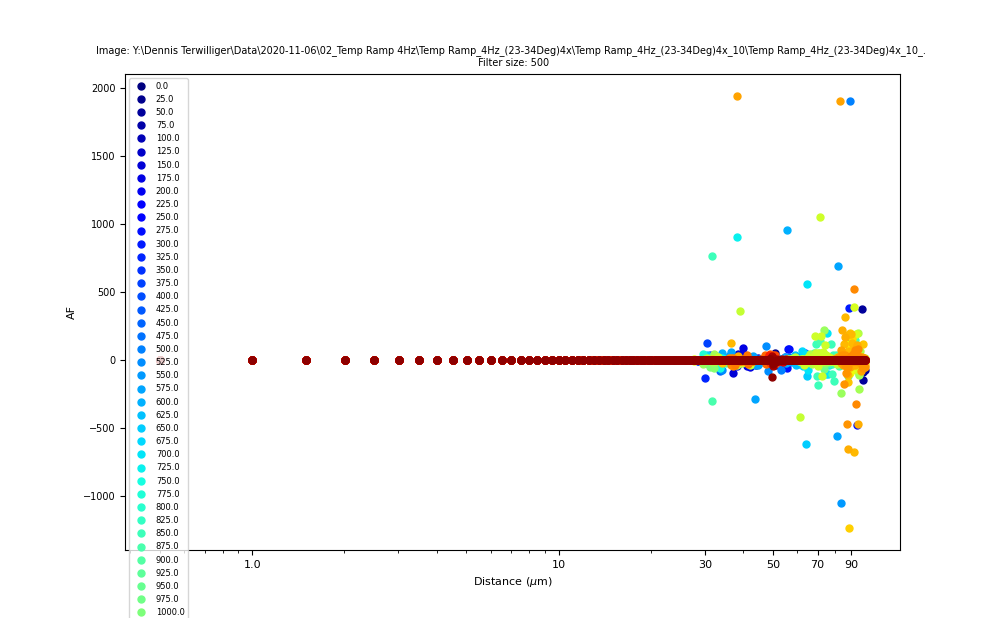

<ipython-input-6-7b4b7cb45013>:25: RuntimeWarning: divide by zero encountered in true_divide
  cos2theta = np.cos(2*np.arctan(1.0*xx/yy))
<ipython-input-6-7b4b7cb45013>:25: RuntimeWarning: invalid value encountered in true_divide
  cos2theta = np.cos(2*np.arctan(1.0*xx/yy))
<ipython-input-3-d5574b746b28>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_im = corr_im.astype(np.float32)


<IPython.core.display.Javascript object>


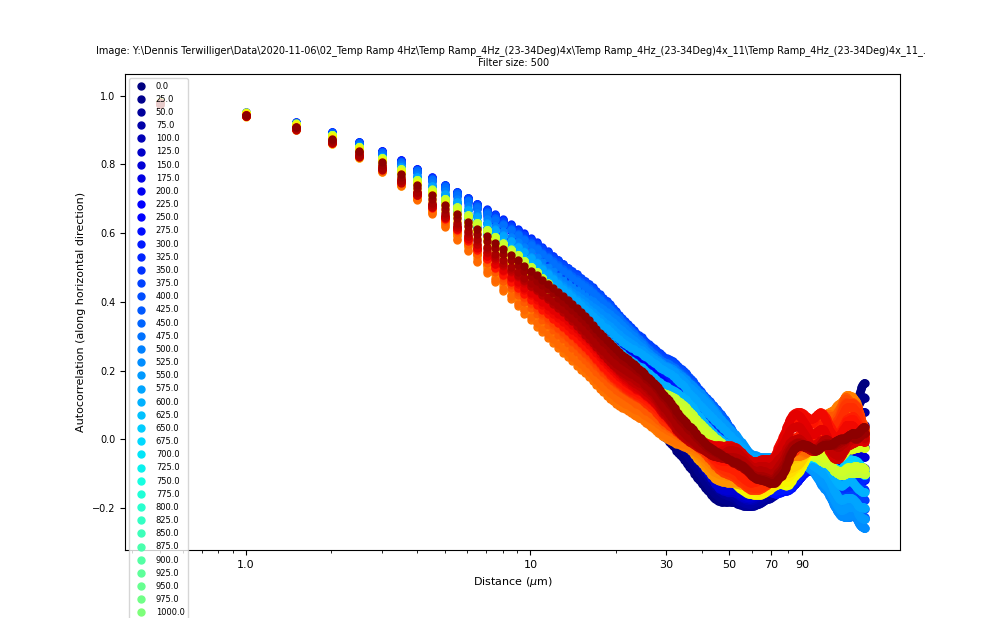

<IPython.core.display.Javascript object>


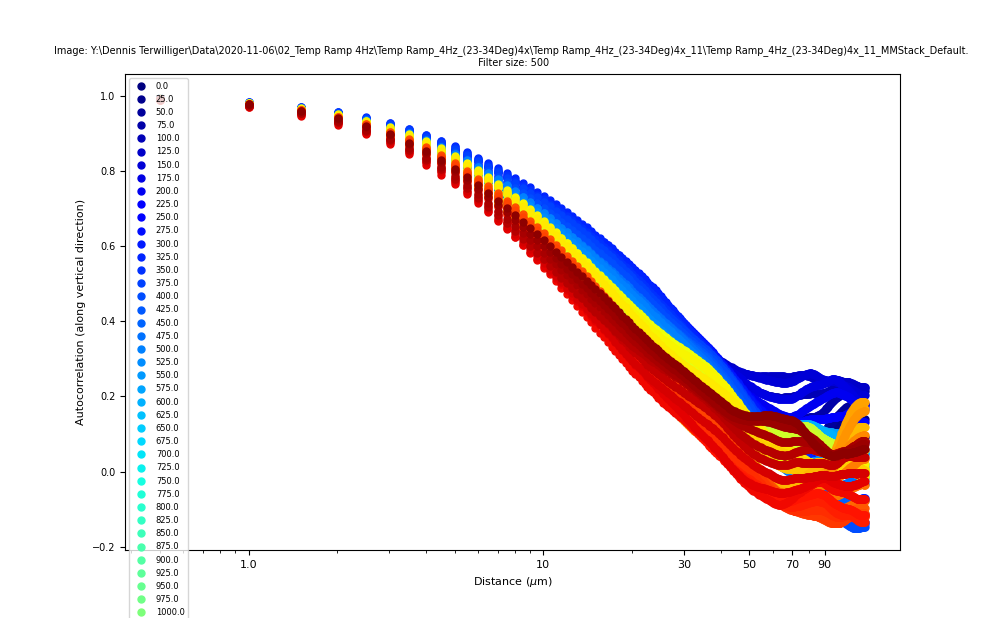

<IPython.core.display.Javascript object>


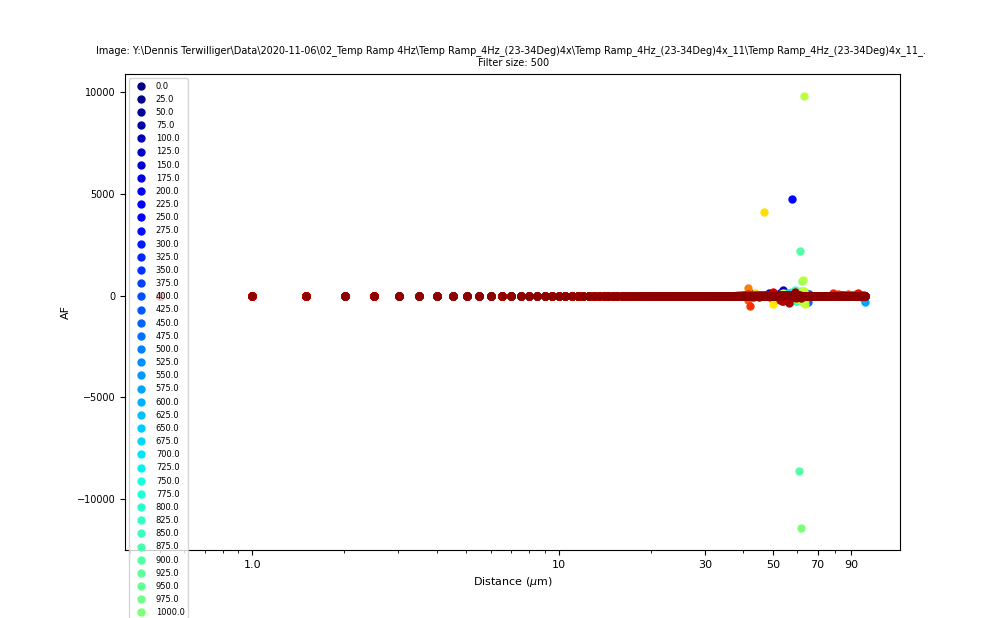

<ipython-input-6-7b4b7cb45013>:25: RuntimeWarning: divide by zero encountered in true_divide
  cos2theta = np.cos(2*np.arctan(1.0*xx/yy))
<ipython-input-6-7b4b7cb45013>:25: RuntimeWarning: invalid value encountered in true_divide
  cos2theta = np.cos(2*np.arctan(1.0*xx/yy))
<ipython-input-3-d5574b746b28>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_im = corr_im.astype(np.float32)


<IPython.core.display.Javascript object>


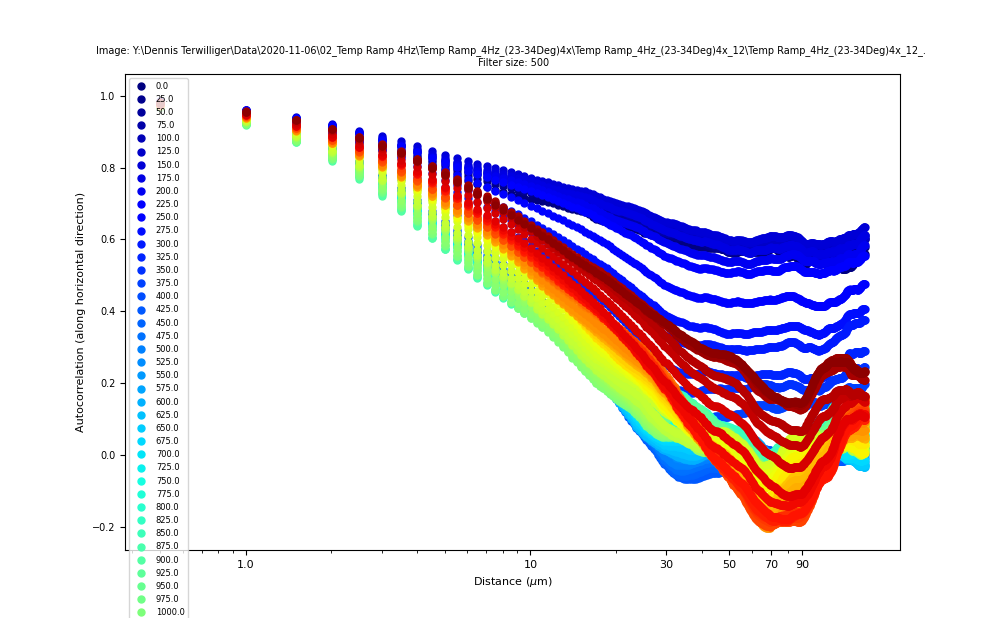

<IPython.core.display.Javascript object>


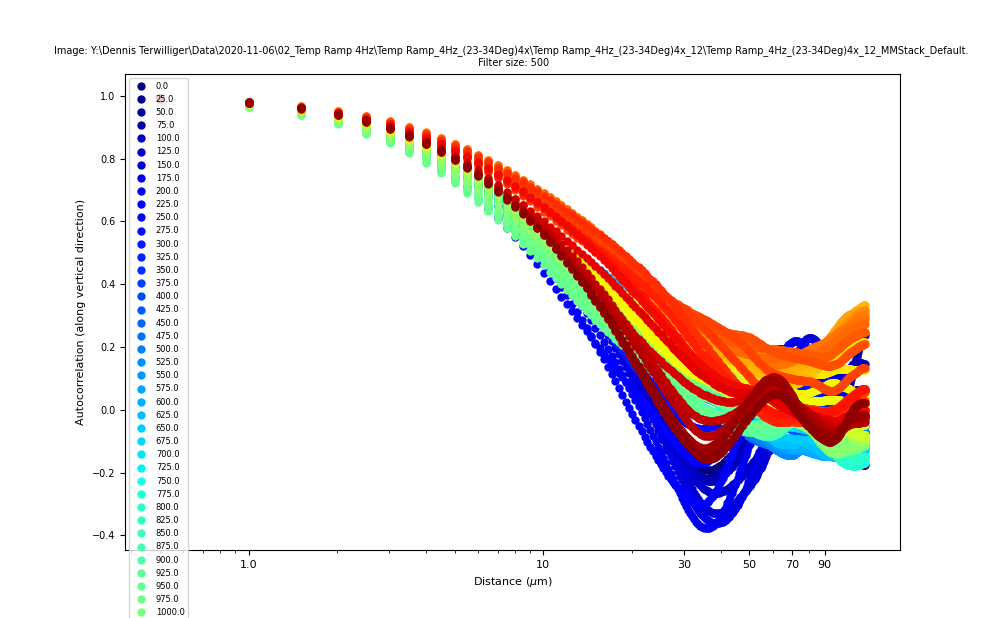

<IPython.core.display.Javascript object>


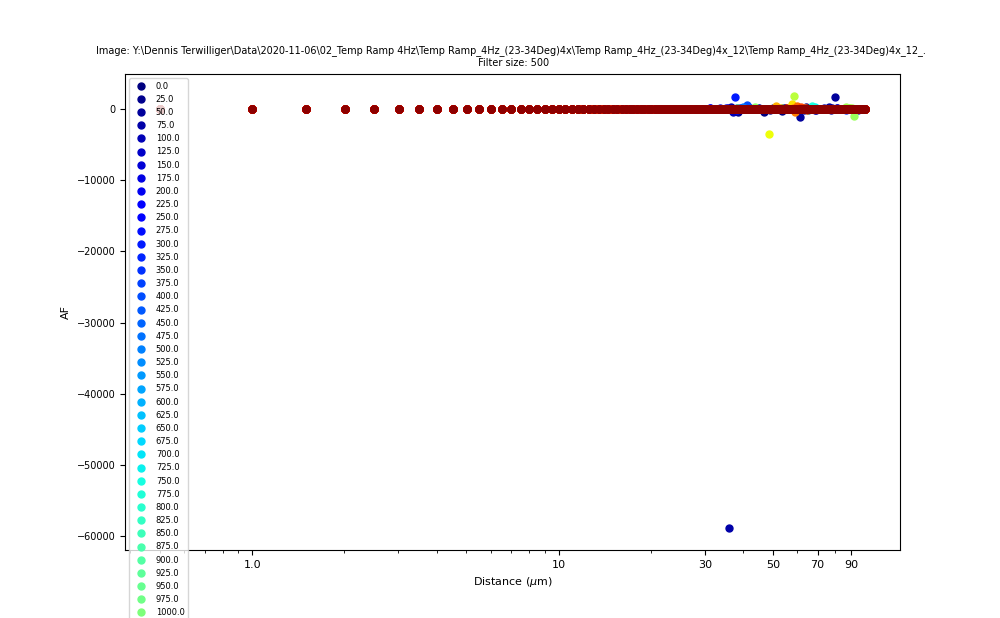

In [6]:
for movie_num in [10,11,12]:
    #data_trial = 10
    shear_rate = 4

    #Set directory where to find the data:
    main_data_dir = "Y:\\Dennis Terwilliger\\Data\\2020-11-06\\02_Temp Ramp %iHz\\" % shear_rate
    data_dir = "Temp Ramp_%iHz_(23-34Deg)4x\\Temp Ramp_%iHz_(23-34Deg)4x_%i\\" % (shear_rate, shear_rate, movie_num)

    data_file = "Temp Ramp_%iHz_(23-34Deg)4x_%i_MMStack_Default.ome.tif" % (shear_rate, movie_num)

    #frames_to_analyze = np.array([70,170,270,370,470,570,670,770,870,970,1070,1170,1270,1370,1470,1570,1670,1770,1870])
    frames_to_analyze = np.arange(0,2000,25)
    num_frames_to_avg = 10
    filtersize=500
    every = 2
    corr_images = np.zeros((len(frames_to_analyze),492,596),dtype=np.float64)
    temp = np.zeros((492,596),dtype=np.float64)
    af = np.zeros((len(frames_to_analyze),200),dtype=np.float64)

    xc = int(corr_images[0].shape[0]/2)
    yc = int(corr_images[0].shape[1]/2)
    x = np.arange(-1*corr_images[0].shape[1]/2, corr_images[0].shape[1]/2, 1)
    y = np.arange(-1*corr_images[0].shape[0]/2, corr_images[0].shape[0]/2, 1)
    xx, yy = np.meshgrid(x, y)
    cos2theta = np.cos(2*np.arctan(1.0*xx/yy))

    for i,frames in enumerate(frames_to_analyze):
        for j in range(num_frames_to_avg):
            im = tiff_file.imread(main_data_dir+data_dir+data_file, key=int(frames+(j*every)))
            temp, corr_rad = im_corr(im[:,60:],filter=True,filtersize=filtersize)
            corr_images[i] = corr_images[i] + temp
        corr_images[i] = corr_images[i] / num_frames_to_avg

        alignment_factor_numerator, _ = radiav.radav(corr_images[i] * cos2theta, xc, yc, 200)
        alignment_factor_denominator, _ = radiav.radav(corr_images[i], xc, yc, 200)

        af[i] = alignment_factor_numerator / alignment_factor_denominator

    ##################################################################################################################
    # PLOTS 
    ##################################################################################################################
    #Here, we plot a *horizontal* slice through the image autocorrelation.
    cmap = matplotlib.cm.get_cmap('jet')
    nx,ny = corr_images[0].shape
    x_mid = int(nx/2); y_mid = int(ny/2)

    figsize = 10.0
    fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
    xvalues = np.arange(y_mid+1)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
    ax.tick_params(axis='both', which='major', labelsize=7)
    markerSize = 5
    mark = 'o'
    j=0
    for i,frames in enumerate(frames_to_analyze):
        plt.semilogx(xvalues, np.flip(corr_images[i,x_mid, 0:y_mid+1]),mark,ms=markerSize,
                     c=cmap(i/(1.0*len(frames_to_analyze))),label="%.1f" % frames)

    plt.xlabel("Distance ($\mu$m)",fontsize=8)
    plt.ylabel("Autocorrelation (along horizontal direction)",fontsize=8)
    plt.title("Image: %s. \n Filter size: %i" % (main_data_dir+data_dir+data_file[:-23], filtersize), fontsize=7)
    plt.legend(loc=0,fontsize=6)

    ax.set_xticks([1.0, 10, 30, 50, 70, 90])
    ax.set_xticklabels(['1.0','10','30','50','70','90'], fontsize=8)
    plt.savefig(main_data_dir+data_dir+data_file[:-23]+"_xcorr_redo_filtsize%i.png" % filtersize)

    #Here, we plot a *vert* slice through the image autocorrelation.
    fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
    xvalues = np.arange(x_mid+1)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
    ax.tick_params(axis='both', which='major', labelsize=7)
    j=0
    for i,frames in enumerate(frames_to_analyze):
        plt.semilogx(xvalues, np.flip(corr_images[i,0:x_mid+1, y_mid]),mark,ms=markerSize,
                     c=cmap(i/(1.0*len(frames_to_analyze))),label="%.1f" % frames)

    plt.xlabel("Distance ($\mu$m)",fontsize=8)
    plt.ylabel("Autocorrelation (along vertical direction)",fontsize=8)
    plt.title("Image: %s. \n Filter size: %i" % (main_data_dir+data_dir+data_file[:-8], filtersize), fontsize=7)
    plt.legend(loc=0,fontsize=6)

    ax.set_xticks([1.0, 10, 30, 50, 70, 90])
    ax.set_xticklabels(['1.0','10','30','50','70','90'], fontsize=8)
    plt.savefig(main_data_dir+data_dir+data_file[:-23]+"_ycorr_redo_filtsize%i.png" % filtersize)

    #Here, we plot the alignmnet factor
    fig, ax = plt.subplots(figsize=(figsize,figsize/1.618))
    xvalues = np.arange(200)*0.501 #For the rheometer microscope with 20x objective pixel size is 0.501um
    ax.tick_params(axis='both', which='major', labelsize=7)
    markerSize = 5
    mark = 'o'
    j=0
    for i,frames in enumerate(frames_to_analyze):
        plt.semilogx(xvalues, af[i],mark,ms=markerSize,
                     c=cmap(i/(1.0*len(frames_to_analyze))),label="%.1f" % frames)

    plt.xlabel("Distance ($\mu$m)",fontsize=8)
    plt.ylabel("AF",fontsize=8)
    plt.title("Image: %s. \n Filter size: %i" % (main_data_dir+data_dir+data_file[:-23], filtersize), fontsize=7)
    plt.legend(loc=0,fontsize=6)


    ax.set_xticks([1.0, 10, 30, 50, 70, 90])
    ax.set_xticklabels(['1.0','10','30','50','70','90'], fontsize=8)
    plt.savefig(main_data_dir+data_dir+data_file[:-23]+"_AF_redo_filtsize%i.png" % filtersize)

    '''
    Alignment factor from: Varga, Z. & Swan, J. W. Large scale anisotropies in sheared colloidal gels. 
    Journal of Rheology 62, 405–418 (2018).

    '''

    ##################################################################################################################
    # Create and save dictionary to pickle file 
    ##################################################################################################################
    af_upto20 = np.zeros((af.shape[0]))
    for i in range(af.shape[0]):
        af_upto20[i] = af[i,1:40].sum()
    dict_to_pickle = {}
    dict_to_pickle['data_dir'] = main_data_dir+data_dir+data_file[:-23]
    dict_to_pickle['filtersize'] = filtersize
    dict_to_pickle['frames_analyzed'] = frames_to_analyze
    dict_to_pickle['num_frames_to_avg'] = num_frames_to_avg
    dict_to_pickle['every'] = every
    dict_to_pickle['corr_images'] = corr_images
    dict_to_pickle['af'] = af
    dict_to_pickle['af_upto20'] = af_upto20
    data_dump_file = open(main_data_dir+data_dir+data_file[:-23]+"_pickleddata_redo_filtsize%i.p" % filtersize,'wb')
    pickle.dump(dict_to_pickle, data_dump_file)
    data_dump_file.close()

## Testing...

In [10]:
shear_rate = 8
movie_num = 9
main_data_dir = "Y:\\Dennis Terwilliger\\Data\\2020-11-05\\05_Temp Ramp %iHz Trial 1\\" % shear_rate
data_dir = "Temp Ramp_%iHz_(23-34Deg)20x\\Temp Ramp_%iHz_(23-34Deg)20x_%i\\" % (shear_rate, shear_rate, movie_num)
data_file = "Temp Ramp_%iHz_(23-34Deg)20x_%i_MMStack_Default.ome.tif" % (shear_rate, movie_num)

im = tiff_file.imread(main_data_dir+data_dir+data_file, key=1900)
corr_test, rav_corr = im_corr(im, filter=True, filtersize=500)

<ipython-input-9-d5574b746b28>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_im = corr_im.astype(np.float32)


<ipython-input-11-0c579b37c894>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


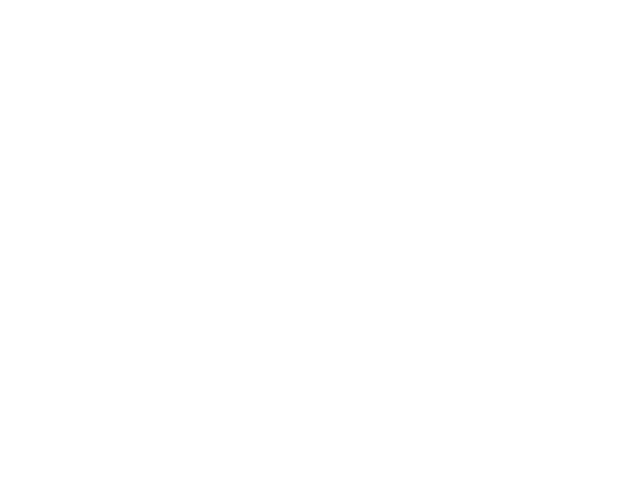

<ipython-input-11-0c579b37c894>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.matshow(corr_test)


<IPython.core.display.Javascript object>


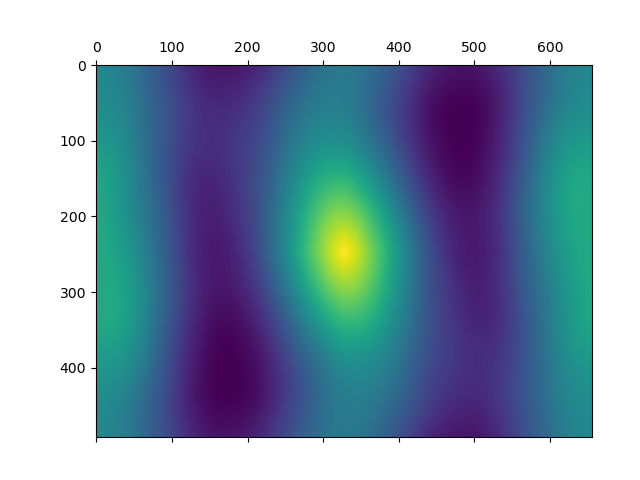

In [11]:
plt.figure()
plt.matshow(corr_test)